In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

companies = ["postman", "figma", "stripe", "airtable", "snyk"]

def fetch_jobs_from_company(token):
    url = f"https://boards-api.greenhouse.io/v1/boards/{token}/jobs?content=true"
    try:
        res = requests.get(url)
        res.raise_for_status()
        jobs = res.json().get("jobs", [])
        for job in jobs:
            job["company"] = token
        return jobs
    except Exception as e:
        print(f"❌ Failed for {token}: {e}")
        return []

def clean_html(html):
    return BeautifulSoup(html, "html.parser").get_text(separator="\n").strip() if html else ""

# Fetch jobs
all_jobs = []
for token in companies:
    jobs = fetch_jobs_from_company(token)
    all_jobs.extend(jobs)

# Convert to DataFrame
df = pd.DataFrame(all_jobs)

# Clean up and flatten fields
df["location"] = df["location"].apply(lambda loc: loc.get("name") if isinstance(loc, dict) else loc)
df["content_clean"] = df["content"].apply(clean_html)

# Select useful fields
df = df[["id", "title", "location", "company", "content_clean"]]

# Preview
df.head()


,id,title,location,company,content_clean
0,6517756003,Account Based Marketing Senior Manager (ABM),"San Francisco, United States",postman,"<div class=""content-intro""><h2><strong>Who Are..."
1,6340592003,Account Development Representative,"San Francisco, United States",postman,"<div class=""content-intro""><h2><strong>Who Are..."
2,5980197003,Account Development Representative,"Boston, United States",postman,"<div class=""content-intro""><h2><strong>Who Are..."
3,6356005003,Account Development Representative (Australia),"Remote, Australia",postman,"<div class=""content-intro""><h2><strong>Who Are..."
4,6513548003,Associate People Business Partner,"San Francisco, United States",postman,"<div class=""content-intro""><h2><strong>Who Are..."


<ipython-input-2-c89e2de5a2c6>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y="role", order=df["role"].value_counts().index, palette="viridis")


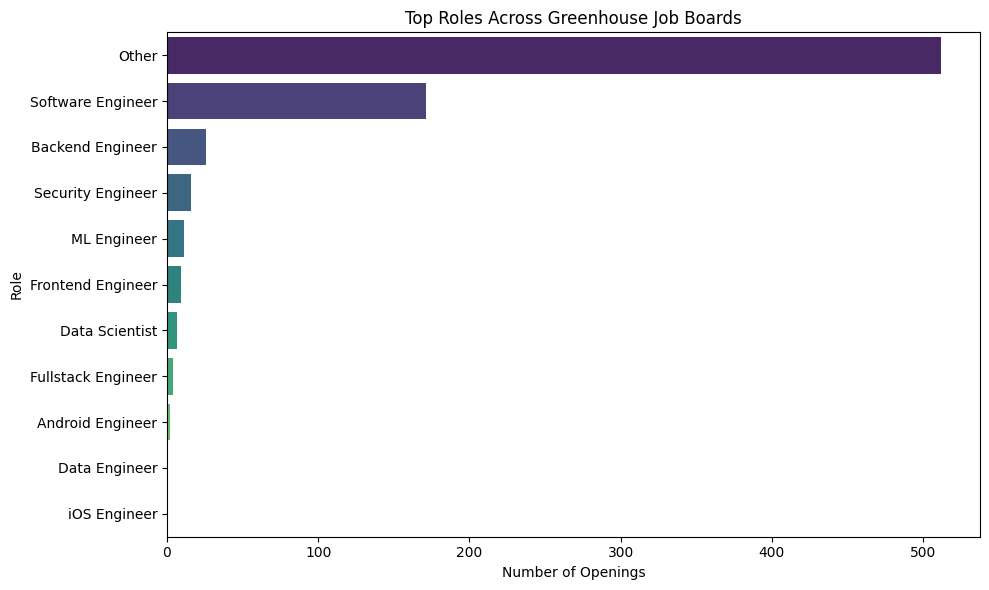

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df["title_clean"] = df["title"].str.lower().str.strip()

def categorize_role(title):
    title = title.lower()
    if "data engineer" in title:
        return "Data Engineer"
    elif "data scientist" in title:
        return "Data Scientist"
    elif "ml" in title or "machine learning" in title:
        return "ML Engineer"
    elif "frontend" in title:
        return "Frontend Engineer"
    elif "backend" in title:
        return "Backend Engineer"
    elif "devops" in title:
        return "DevOps Engineer"
    elif "fullstack" in title or "full-stack" in title:
        return "Fullstack Engineer"
    elif "security" in title:
        return "Security Engineer"
    elif "ios" in title:
        return "iOS Engineer"
    elif "android" in title:
        return "Android Engineer"
    elif "software" in title or "engineer" in title:
        return "Software Engineer"
    else:
        return "Other"

df["role"] = df["title_clean"].apply(categorize_role)

plt.figure(figsize=(10, 6))
sns.countplot(data=df, y="role", order=df["role"].value_counts().index, palette="viridis")
plt.title("Top Roles Across Greenhouse Job Boards")
plt.xlabel("Number of Openings")
plt.ylabel("Role")
plt.tight_layout()
plt.show()


Reddit PRAW API

In [ ]:
pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 4.7 MB/s eta 0:00:00


In [ ]:
import praw
from google.colab import userdata

praw_client_id = userdata.get('praw_client_id')
praw_client_secret = userdata.get('praw_client_secret')

reddit = praw.Reddit(client_id = praw_client_id,client_secret = praw_client_secret,user_agent = "test")

def fetch_posts(subreddit_name, limit=10, min_upvotes=100):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []

    for post in subreddit.hot(limit=limit):
        if post.score >= min_upvotes and not post.stickied:
            posts.append({
                'title': post.title,
                'selftext': post.selftext,
                'score': post.score,
                'url': post.url,
                'created_utc': post.created_utc,
                'permalink': f"https://reddit.com{post.permalink}"
            })

    return posts

In [ ]:
results = fetch_posts("jobsearchhacks",limit=15)

for post in results:
    print(f"Title: {post['title']}")
    print(f"Score: {post['score']}")
    print(f"Permalink: {post['permalink']}")
    print(f"Content:\n{post['selftext'][:300]}...\n")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Title: More than 70% reported receiving no feedback after the interview...
Score: 159
Permalink: https://reddit.com/r/jobsearchhacks/comments/1jqqr0j/more_than_70_reported_receiving_no_feedback_after/
Content:
It's okay to reject candidates as you can't hire everyone, but job seekers at least want feedback and the reason for their rejection, so they can improve in future interviews. If you attend an interview and don't receive any response, you were rejected for one of these [8 reasons](https://upperclass...

Title: Has anyone used Applyre?
Score: 474
Permalink: https://reddit.com/r/jobsearchhacks/comments/1jqha2x/has_anyone_used_applyre/
Content:
Has anyone tried to Applyre to apply for jobs? Looking for honest reviews from real people. After looking into past mentions of Applyre on Reddit, it looks like they could be from employees (or AI) rather than real people who have used the service and given their opinion. Any insights would be appre...

Title: Are you finding interviews harde

In [ ]:
def search_posts(subreddit_name, query, limit=10, min_upvotes=10):
    """
    Search Reddit posts by keyword in a specific subreddit.
    Filters by minimum upvotes.
    """
    subreddit = reddit.subreddit(subreddit_name)
    posts = []

    for post in subreddit.search(query, limit=limit, sort='relevance'):
        if post.score >= min_upvotes and not post.stickied:
            posts.append({
                'title': post.title,
                'selftext': post.selftext,
                'score': post.score,
                'url': post.url,
                'created_utc': post.created_utc,
                'permalink': f"https://reddit.com{post.permalink}"
            })

    return posts

In [ ]:
keyword = "data engineer"
results = search_posts("jobsearchhacks", keyword, limit=10)

for post in results:
    print(f"Title: {post['title']}")
    print(f"Score: {post['score']}")
    print(f"Permalink: {post['permalink']}")
    print(f"Content:\n{post['selftext'][:300]}...\n")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Title: I made a free tool to spot companies on linkedin that ghost or have bad ratings on glassdoor. 
Score: 1007
Permalink: https://reddit.com/r/jobsearchhacks/comments/1i22nxd/i_made_a_free_tool_to_spot_companies_on_linkedin/
Content:
...

Title: Ghosted after interview - calling them out!
Score: 490
Permalink: https://reddit.com/r/jobsearchhacks/comments/1j9sbts/ghosted_after_interview_calling_them_out/
Content:
This is the most pathetic interaction I’ve ever had in my professional career. I had an interview with an Engineering Manager for a Data Analyst role, I prepared for our call, it seemed to go well and it was implied that there would be next steps. I followed up 3 times over a 4-week period and never...

Title: LinkedIn Tricks To Get Recruiters To Message You (Reverse engineering LinkedIn Recruiting)
Score: 366
Permalink: https://reddit.com/r/jobsearchhacks/comments/1iubn7d/linkedin_tricks_to_get_recruiters_to_message_you/
Content:
Helping people get jobs and building cool st

In [ ]:
#youtube info
from google.colab import userdata
import requests
import pandas as pd

api_key = userdata.get('SERP_API_KEY')
if not api_key:
    raise ValueError("API key not found in Colab userdata!")

class YouTubeSearchScraper:
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.base_url = "https://serpapi.com/search"

    def search(self, query: str):
        params = {
            "engine": "youtube",
            "search_query": query,
            "api_key": self.api_key
        }

        response = requests.get(self.base_url, params=params)

        if response.status_code != 200:
            raise Exception(f"Failed to fetch results: {response.status_code} - {response.text}")

        self.results = response.json()
        return self.results

    def to_dataframe(self):
        video_results = self.results.get("video_results", [])
        df = pd.DataFrame(video_results)

        expected_cols = ["title", "link", "published", "views", "channel", "description"]
        available_cols = [col for col in expected_cols if col in df.columns]

        if not df.empty and available_cols:
            df = df[available_cols]
        return df

# Use it
yt_scraper = YouTubeSearchScraper(api_key=api_key)
yt_scraper.search("llm")
df_videos = yt_scraper.to_dataframe()
df_videos.head()



,title,link,views,channel,description
0,Large Language Models explained briefly,https://www.youtube.com/watch?v=LPZh9BOjkQs,2092890,"{'name': '3Blue1Brown', 'link': 'https://www.y...","No secret end-screen vlog for this one, the en..."
1,[1hr Talk] Intro to Large Language Models,https://www.youtube.com/watch?v=zjkBMFhNj_g,2674380,"{'name': 'Andrej Karpathy', 'link': 'https://w...",This is a 1 hour general-audience introduction...
2,How Large Language Models Work,https://www.youtube.com/watch?v=5sLYAQS9sWQ,887144,"{'name': 'IBM Technology', 'link': 'https://ww...",Large language models-- or LLMs --are a type o...
3,Deep Dive into LLMs like ChatGPT,https://www.youtube.com/watch?v=7xTGNNLPyMI,2128830,"{'name': 'Andrej Karpathy', 'link': 'https://w...",This is a general audience deep dive into the ...
4,"Developing an LLM: Building, Training, Finetuning",https://www.youtube.com/watch?v=kPGTx4wcm_w,93534,"{'name': 'Sebastian Raschka', 'link': 'https:/...",DESCRIPTION: This video provides an overview o...


In [ ]:
#articles info
from google.colab import userdata
import requests
import pandas as pd

# Step 1: Get secret API key
rapidapi_key = userdata.get("DEVTO_KEY")

if not rapidapi_key:
    raise ValueError("RAPIDAPI_KEY not found in Colab userdata!")

# Step 2: Define the scraper class
class DevToArticleScraper:
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.base_url = "https://dev.to/api/articles"
        self.headers = {
            "x-rapidapi-host": "dev-to-api1.p.rapidapi.com",
            "x-rapidapi-key": self.api_key
        }

    def search(self, tag: str = "llm", per_page: int = 5):
        params = {
            "tag": tag,
            "per_page": per_page
        }

        response = requests.get(self.base_url, headers=self.headers, params=params)

        if response.status_code != 200:
            raise Exception(f"API call failed: {response.status_code} - {response.text}")

        self.results = response.json()
        return self.results

    def to_dataframe(self):
        df = pd.DataFrame(self.results)

        expected_cols = ["title", "url", "published_at", "description", "tags"]
        available_cols = [col for col in expected_cols if col in df.columns]

        if not df.empty and available_cols:
            df = df[available_cols]

        return df

# Step 3: Use the scraper
dev_scraper = DevToArticleScraper(api_key=rapidapi_key)
dev_scraper.search(tag="llm", per_page=5)
df_articles = dev_scraper.to_dataframe()
df_articles.head()


,title,url,published_at,description,tags
0,Announcing: Native Support for LangChain,https://dev.to/gentoro/announcing-native-suppo...,2025-04-03T15:42:00Z,LangChain has quickly become the go-to framewo...,"langchain, llm, mcp, genai"
1,My explanation of the rising Model Context Pro...,https://dev.to/zeedu_dev/my-explanation-of-the...,2025-04-04T17:42:35Z,I explain the Model Context Protocol or MCP us...,"ai, softwarearhitecture, llm"
2,Building a Basic MCP Server with Python,https://dev.to/alexmercedcoder/building-a-basi...,2025-04-04T18:44:55Z,Free Resources Free Apache Iceberg Course ...,"ai, langchain, mcp, llm"
3,Do you use LLMs? And some podcast recommendations,https://dev.to/adolfont/do-you-use-llms-and-so...,2025-04-04T16:30:06Z,"Right now, I am using LLMs to (a few examples)...","ai, llm"
4,Vector Dimensions: Handle with Care!,https://dev.to/sathish/vector-dimensions-handl...,2025-04-04T15:16:00Z,"""Dimensions aren't just numbers — they're the ...","ai, llm"


In [ ]:
#udemy info
from google.colab import userdata
import requests
import pandas as pd

# Step 1: Get your RapidAPI key securely
rapidapi_key = userdata.get("UDEMY_KEY")  # Make sure this secret is already set in Colab

if not rapidapi_key:
    raise ValueError("UDEMY_KEY not found in Colab secrets!")

# Step 2: Define the Udemy course scraper class
class UdemyCourseScraper:
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.base_url = "https://udemy-paid-courses-for-free-api.p.rapidapi.com/rapidapi/courses/search"
        self.headers = {
            "x-rapidapi-host": "udemy-paid-courses-for-free-api.p.rapidapi.com",
            "x-rapidapi-key": self.api_key
        }

    def search(self, query: str = "AI", page: int = 1, page_size: int = 10):
        params = {
            "query": query,
            "page": page,
            "page_size": page_size
        }

        response = requests.get(self.base_url, headers=self.headers, params=params)

        if response.status_code != 200:
            raise Exception(f"API call failed: {response.status_code} - {response.text}")

        self.results = response.json()
        return self.results

    def to_dataframe(self):
        courses = self.results.get("courses", [])
        df = pd.DataFrame(courses)

        expected_cols = ["title", "url", "price", "rating", "content_info", "visible_instructors"]
        available_cols = [col for col in expected_cols if col in df.columns]

        if not df.empty and available_cols:
            df = df[available_cols]

        return df

# Step 3: Use it
udemy_scraper = UdemyCourseScraper(api_key=rapidapi_key)
udemy_scraper.search(query="AI", page=1, page_size=10)
df_courses = udemy_scraper.to_dataframe()
df_courses.head()


,url
0,https://www.udemy.com/course/icf-professional-...
1,https://www.udemy.com/course/generative-ai-for...
2,https://www.udemy.com/course/javascript-coding...
3,https://www.udemy.com/course/python-interview-...
4,https://www.udemy.com/course/css-fundamentals-...


In [ ]:
#glassdoor with only 1 final step
# glassdoor interview info
from google.colab import userdata
import requests
import pandas as pd

# Step 1: Get your RapidAPI key securely
rapidapi_key = userdata.get("GLASSDOOR_KEY")  # Make sure this secret is already set in Colab

if not rapidapi_key:
    raise ValueError("GLASSDOOR_KEY not found in Colab secrets!")

# Step 2: Define the Glassdoor interview detail fetcher class
class GlassdoorInterviewDetailFetcher:
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.base_url = "https://glassdoor-real-time.p.rapidapi.com/companies/interview-details"
        self.headers = {
            "x-rapidapi-host": "glassdoor-real-time.p.rapidapi.com",
            "x-rapidapi-key": self.api_key
        }

    def fetch(self, interview_id: str):
        params = {"interviewId": interview_id}
        response = requests.get(self.base_url, headers=self.headers, params=params)

        if response.status_code != 200:
            raise Exception(f"API call failed: {response.status_code} - {response.text}")

        self.results = response.json()
        return self.results

    def to_dataframe(self):
        detail = self.results.get("data", {}).get("employerInterviewDetails", {})
        df = pd.json_normalize(detail)

        expected_cols = ["employer.name", "difficulty", "experience", "countHelpful", "employer.squareLogoUrl", "jobTitle.text", "outcome", "reviewDateTime", "source", "processDescription"]
        available_cols = [col for col in expected_cols if col in df.columns]

        if not df.empty and available_cols:
            df = df[available_cols]

        return df

# Step 3: Use it
glassdoor_fetcher = GlassdoorInterviewDetailFetcher(api_key=rapidapi_key)
glassdoor_fetcher.fetch(interview_id="4168541")
df_interview = glassdoor_fetcher.to_dataframe()
df_interview.head()


,employer.name,difficulty,experience,countHelpful,employer.squareLogoUrl,jobTitle.text,outcome,reviewDateTime,source,processDescription
0,Google Inc.,DIFFICULT,POSITIVE,2483,https://media.glassdoor.com/sql/9079/google-sq...,Software Engineer,ACCEPT_OFFER,2014-05-04T20:53:03.517Z,EMPLOYEE_REFERRAL,Direct onsite because I interviewed in the pas...
